<img align="right" src="./img/DEP.png" width="400px">

# Data Exploration on Open EU COVID-19 data (with HiveQL)

*Apache Hadoop* is a collection of open-source softwares and tools to deal with problems that arise when working with massive amounts of data and computation, also called the Big Data problem. For example, 
- large clinical datasets need to be processed effectively for optimization drugs and treatments,
- the transport sector needs to process its large datasets of sensors, GPS data and social media for managing smart city traffic flows.

More examples can be found on: [What can big data do for you?](https://ec.europa.eu/digital-single-market/en/what-can-big-data-do-you).

Apache Hadoop provides frameworks for distributing storage and processing on different computer hardwares, called computer nodes that forms a *Hadoop cluster*. Hadoop consists mainly of three parts:
- The distributed storage part of Hadoop is called the *Hadoop Distributed File System (HDFS)*.
- The distributed processing part of Hadoop is called the *MapReduce*.
- The platform for managing and scheduling computing resources on clusters is called *YARN*.

*Apache Hive* is one of the data warehouse software packages that is installed on top of or alongside Hadoop and works with data query for dealing with data. Apache Hive is an easily scalable SQL-like interface to query data from various databases and file systems integrated with Apache Hadoop. It supports analysis of large datasets stored in Hadoop HDFS and is compatible with *Amazon S3 filesystem* and *Alluxio*.

In this notebook, we will explore some of the basic capabilities of the HiveQL for the data science's role to explore,
analyze and visualize big data. For numerical analysis of tabular data, Hive Tables is suited for working with two-dimensional tables of data.

In this tutorial, we shall use the worldwide COVID-19 data up to 30 November 2020, extracted from the [EU Open Data Portal](https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data). Every day between 6.00 and 10.00 CET, a team of epidemiologists screens up to 500 relevant sources to collect the latest figures. The data screening is followed by ECDC’s standard epidemic intelligence process for which every single data entry is validated and documented in an ECDC database.

Contents:
- Exploring tabular data with HiveQL
- Visualize data with Matplotlib
- Analyzing tabular data with HiveQL
- Descriptive analysis
- Statistical analysis
- Appendix 1: The normal distribution
- Clean-up

What you will learn:
- Exploring large tabular data with query commands using HiveQL 
- Make customized data visualization with Matplotlib package using Python
- Introduction on how to describe your data using HiveQL
- Introduction to statistical terminology and statistical visualization to describe your data

Remark:
- You have to run the code cells in sequence. Some code blocks may depend on variables from previous code blocks.
- It is recommended to setup the HiveQL environment before executing the following Python codes. This might be timeconsuming, but in the Big Data Test Infrastructure (BDTI), this HiveQL environment will be set up for you. Furthermore, you can utilize the BDTI resources to do computational heavy calculations and data storage.

Source:
- [Microsoft's ml-basics tutorials](https://github.com/MicrosoftDocs/ml-basics)
- [Spark documentation](https://spark.apache.org/docs/latest/)
- [Pandas documentation](https://pandas.pydata.org/docs/)
- [Matplotlib documentation](https://matplotlib.org/3.3.2/contents.html)

## Exploring tabular data with HiveQL

First and foremost, we have to start the Spark session. This Spark session needs to support HiveQL queries by including **enableHiveSupport()**.

In [1]:
from os.path import join, abspath

from pyspark.sql import SparkSession
from pyspark.sql import Row

# warehouse_location points to the default location for managed databases and tables
warehouse_location = 's3://aws-emr-resources-612470128176-eu-west-1/notebooks/e-ES2PRUKVRT96HAUVMYLCIVRIF/spark-warehouse'

# Starting a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration session") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

VBox()

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We observe that the Spark application has been started and a *Spark session* is available, named *spark*.

The dataset is saved on an AWS S3 bucket in the folder eu-open-data in *csv-format*. This is a common data format where the information is delimited using a symbol such as **,** or **;**. First we will import this data as a Spark DataFrame, the **read** method can be used. In this method, you need to provide **options**: whether a *header* is used in the dataset and whether a *schema* can be inferred. The header can contain information what the numbers of the tabular data represents and the schema is which format they are in (integers, floating point numbers, strings).

More information on the SPARK DataFrame can be found in the [Apache SPARK documentation](https://spark.apache.org/docs/latest/sql-programming-guide.html).

> Remark: To import data from other file formats, please look into Appendix 2.

In [2]:
# Import the data from S3 bucket
s3_covid = "s3://bdti-example-data-public-eu-west-1/eu-open-data/COVID-19-geographic-disbtribution-worldwide-online-older.csv"
covid_data = spark.read.option("header", "true").option("inferSchema", "true").csv(s3_covid)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The inferred schema can be displayed using the **printSchema** method,

In [3]:
covid_data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- dateRep: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- countriesAndTerritories: string (nullable = true)
 |-- geoId: string (nullable = true)
 |-- countryterritoryCode: string (nullable = true)
 |-- popData2019: integer (nullable = true)
 |-- continentExp: string (nullable = true)
 |-- Cumulative_number_for_14_days_of_COVID-19_cases_per_100000: double (nullable = true)

The *nullable = true* allows for missing values in the DataFrame. It seems that PySpark has inferred the schema quite well. We observe that the dataset contains information such as:
- The date of the logged COVID-19 cases (dateRep, day, month, year)
- The number of COVID-19 cases (cases)
- The number of COVID-19 deaths (deaths)
- The country or territory of the COVID-19 numbers and identifiers (countriesAndTerritories, geoID, countryterritoryCode)
- The population of the country or territory as of 2019 (popData2019)
- The continitent of the country or territory (continentExp)
- The cumulative number for 14 days of COVID-19 cases (per 100 000).

To work further with HiveQL, you need to create a Hive Table from the Spark DataFrame. Then, you can create an Hive Table from this temporary table using the SQL-query **CREATE ... FROM ...**. The SQL-query creates a Hive table from the temporary view.

In [4]:
# Write the Spark DataFrame as Hive Table.
covid_data.write.mode("overwrite").saveAsTable("covid_table")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

To display the whole tabular data from this table, use the **SELECT** query followed by * indicating that you want to select everything. The results can be shown by appending the **show** method.

In [5]:
# Display the resulting Hive table
spark.sql("SELECT * FROM covid_table").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+-----------+------------+----------------------------------------------------------+
|   dateRep|day|month|year|cases|deaths|countriesAndTerritories|geoId|countryterritoryCode|popData2019|continentExp|Cumulative_number_for_14_days_of_COVID-19_cases_per_100000|
+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+-----------+------------+----------------------------------------------------------+
|14/12/2020| 14|   12|2020|  746|     6|            Afghanistan|   AF|                 AFG|   38041757|        Asia|                                                9.01377925|
|13/12/2020| 13|   12|2020|  298|     9|            Afghanistan|   AF|                 AFG|   38041757|        Asia|                                                7.05277624|
|12/12/2020| 12|   12|2020|  113|    11|            Afghanistan|   AF|                 AFG|   38041757|        Asia|    

It is important to note that the data is still stored in the S3 bucket and that Hive only stores metadata (e.g. the schema of the table). To display the metadata, use the **DESC** query.

In [6]:
spark.sql("DESC FORMATTED covid_table").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------+
|            col_name|           data_type|comment|
+--------------------+--------------------+-------+
|             dateRep|              string|   null|
|                 day|                 int|   null|
|               month|                 int|   null|
|                year|                 int|   null|
|               cases|                 int|   null|
|              deaths|                 int|   null|
|countriesAndTerri...|              string|   null|
|               geoId|              string|   null|
|countryterritoryCode|              string|   null|
|         popData2019|                 int|   null|
|        continentExp|              string|   null|
|Cumulative_number...|              double|   null|
|                    |                    |       |
|# Detailed Table ...|                    |       |
|            Database|             default|       |
|               Table|         covid_table|       |
|           

Imagine you want to return a particular row and columns of this Hive Table. 
- A particular column of the Table can be selected using the **SELECT** query. 
- A particular row given a boolean condition can be be selected using the **WHERE** query.

The results can be shown by appending the **show** method.

For example, the COVID-19 cases of Belgium on 6th May 2020 can be extracted by the following code cell, which 
- Selects the cases column
- Filters on the desired date
- Filters on the Belgium COVID-19 data

More than one boolean conditions can be given by using the **AND** query:

In [7]:
spark.sql("SELECT cases FROM covid_table WHERE dateRep == '06/05/2020' AND countriesAndTerritories == 'Belgium' ").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+
|cases|
+-----+
|  547|
+-----+

Let us save the Belgium COVID-19 cases in a *temporary view* from the full Hive Table. Temporary views do not contain data of its own and can be seen as a "virtual table". However, all Hive queries will work on temporary views.

In [8]:
spark.sql("CREATE VIEW IF NOT EXISTS covid_bel_view AS SELECT dateRep, cases, deaths FROM covid_table WHERE countriesAndTerritories == 'Belgium' ")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[]

## Visualize data with Matplotlib

*Matplotlib* is a comprehensive library for creating static, animated, and interactive visualizations in Python. We shall demonstrate its capabilities on the COVID-19 data. More information on the Matplotlib package can be found in the [Matplotlib documentation](https://matplotlib.org/3.3.2/contents.html). We need to transform Hive Table into a Pandas DataFrame to visualize.

 > Remark: You can only visualize your data this way when the resulting Pandas Dataframe is small enough to fit on the master node attached to your notebook.

First, you need to install the Matplotlib and the Pandas package on the cluster attached to your notebook using the *install_pypi_package* API.

In [9]:
sc = spark.sparkContext
sc.install_pypi_package("pandas") #Install pandas
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") #Install matplotlib from given PyPI repository

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/f3/d4/3fe3b5bf9886912b64ef040040aec356fa48825e5a829a84c2667afdf952/pandas-1.2.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/23/3d/db9a6b3c83c9511301152dbb64a029c3a4313c86eaef12c237b13ecf91d6/matplotlib-3.3.4-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1f/6d/b719ae8e21660a6a962636896dc4b7d657ef451a3ab941516401846ac5cb/Pillow-8.1.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using ca

In [10]:
print("Installed packages on cluster:\n")
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Installed packages on cluster:

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
cycler                     0.10.0   
jmespath                   0.10.0   
joblib                     0.16.0   
kiwisolver                 1.3.1    
lxml                       4.5.2    
matplotlib                 3.3.4    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.2.3    
Pillow                     8.1.2    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  2.4.7    
python-dateutil            2.8.1    
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
setuptools                 28.8.0   
six   

Then, you can import the matplotlib package as an object **plt**. Using its **plot** method, you can specify the x-axis and its y-axis values. Finally, the plot can be displayed using the **%matplot** magic function. Like this,

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

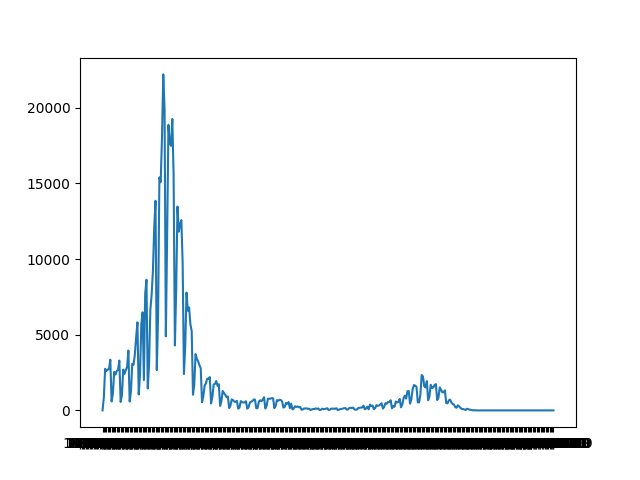

In [11]:
from matplotlib import pyplot as plt

covid_bel_pandasdf = spark.sql("SELECT * FROM covid_bel_view").toPandas()

# Create a bar plot of date vs COVID-19 cases
plt.plot(covid_bel_pandasdf.dateRep, covid_bel_pandasdf.cases)

# Display the plot (render the plot on the attached EMR cluster)
%matplot plt

We observe that the above plot needs some improvements. *Matplotlib* offers a wide range of customization that can be applied to your plot. The following code:
- Specifies a bigger figure dimension
- Adds a title to the chart (so we know what it represents)
- Adds labels to the X and Y (so we know which axis shows which data)
- Adds a grid (to make it easier to determine the values for the bars)
- Rotates the X markers (so we can read them)
- Fixes the convention that dates should be ascending
- Displays every 10 date ticks on the x-axis instead of all (to make it more readable)

There is no need to memorize codes for customizing a plot. 
The best method for drawing a visual pleasing plot is by looking up the right commands online and trail-and-error. For example, you can consult [stackoverflow](https://stackoverflow.com/), which is a huge developer community where people post their coding problems and bugs for the community to solve. Another option is to consult your favorite search engine.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

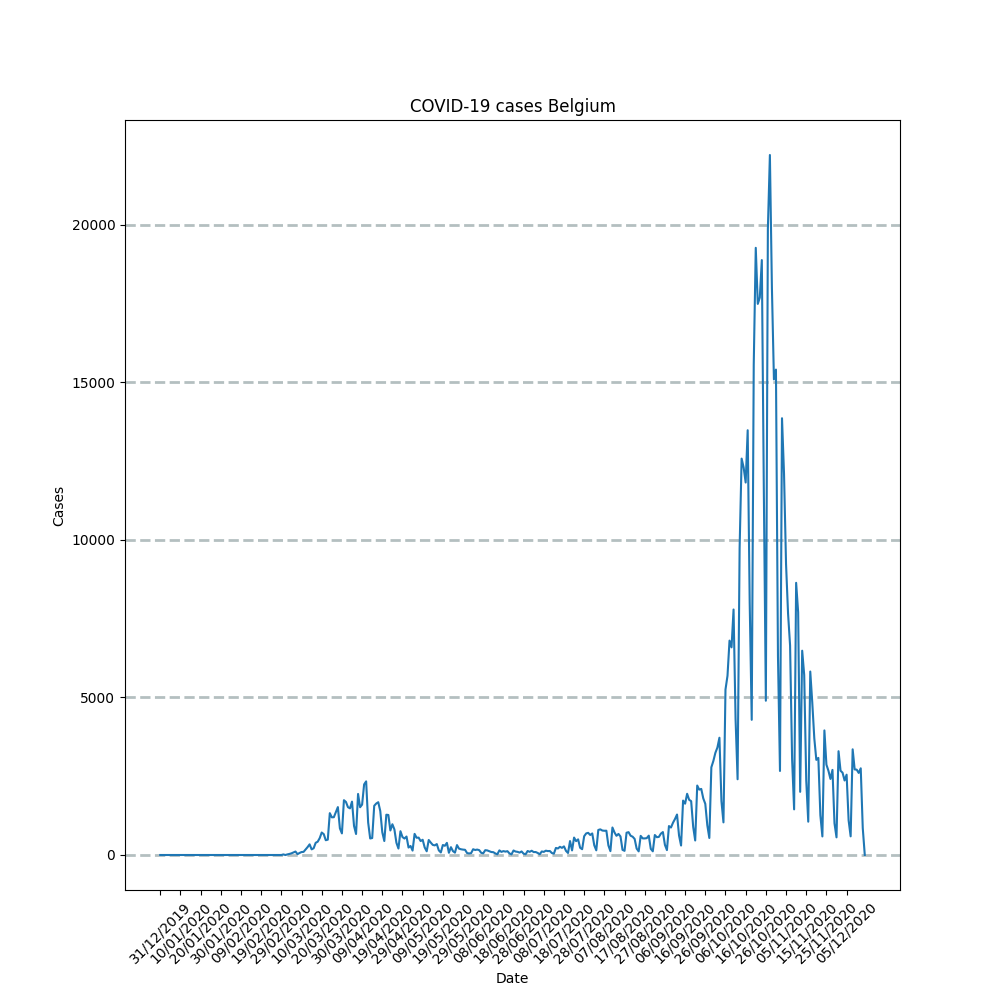

In [12]:
import numpy as np

# Create a Figure with specified figure size.
fig = plt.figure(figsize=(10,10))

# Create a plot of date vs COVID-19 cases
plt.plot(covid_bel_pandasdf.dateRep.loc[::-1], covid_bel_pandasdf.cases.loc[::-1])

x = np.arange(covid_bel_pandasdf.shape[0])
every = 10

# Customize the chart
plt.title('COVID-19 cases Belgium')
plt.xlabel('Date')
plt.xticks(np.arange(min(x), max(x)+1, every))
plt.ylabel('Cases')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Display the plot

### How to fix the date issue below?
%matplot plt

Now that is way better! We observe that there are periodical wells of COVID-19 cases in Belgium. This is because the COVID-19 cases in the weekends are not registered in the same manner as during the weekdays.
To plot a more representative plot, we can plot the weekly average of the COVID-19 cases in Belgium (this is also done in the Belgian news).
This can be achieved by the following code cell.

In [13]:
# Function for calculating the weekaverages
def calc_weekly_averages(dates, cases):
    DAYS_TO_AVERAGE_OVER = 7
    # Calculate weekly averages
    avgs = []
    for i in range(DAYS_TO_AVERAGE_OVER, cases.size):
        w = cases[i-DAYS_TO_AVERAGE_OVER:i]
        avgs.append(w.mean())

    # Update the dates that correspond to these weekly averages
    dates = dates.iloc[DAYS_TO_AVERAGE_OVER::]

    # Return the derived variables
    return dates, avgs

# Calculate the weekly averages for the Belgium COVID-19 cases.
weekly_avg_bel_dates = covid_bel_pandasdf.dateRep.loc[::-1]
weekly_avg_bel_cases = covid_bel_pandasdf.cases.loc[::-1]
weekly_avg_bel_dates, weekly_avg_bel_cases = calc_weekly_averages(weekly_avg_bel_dates, weekly_avg_bel_cases)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The above code cell defines a custom Python function *calc_weekly_averages* that calculates the weekly average given the dates and the cases of a particular period.

Let us now plot the weekly averages of the COVID-19 cases of Belgium, using the same custom plot defined above.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

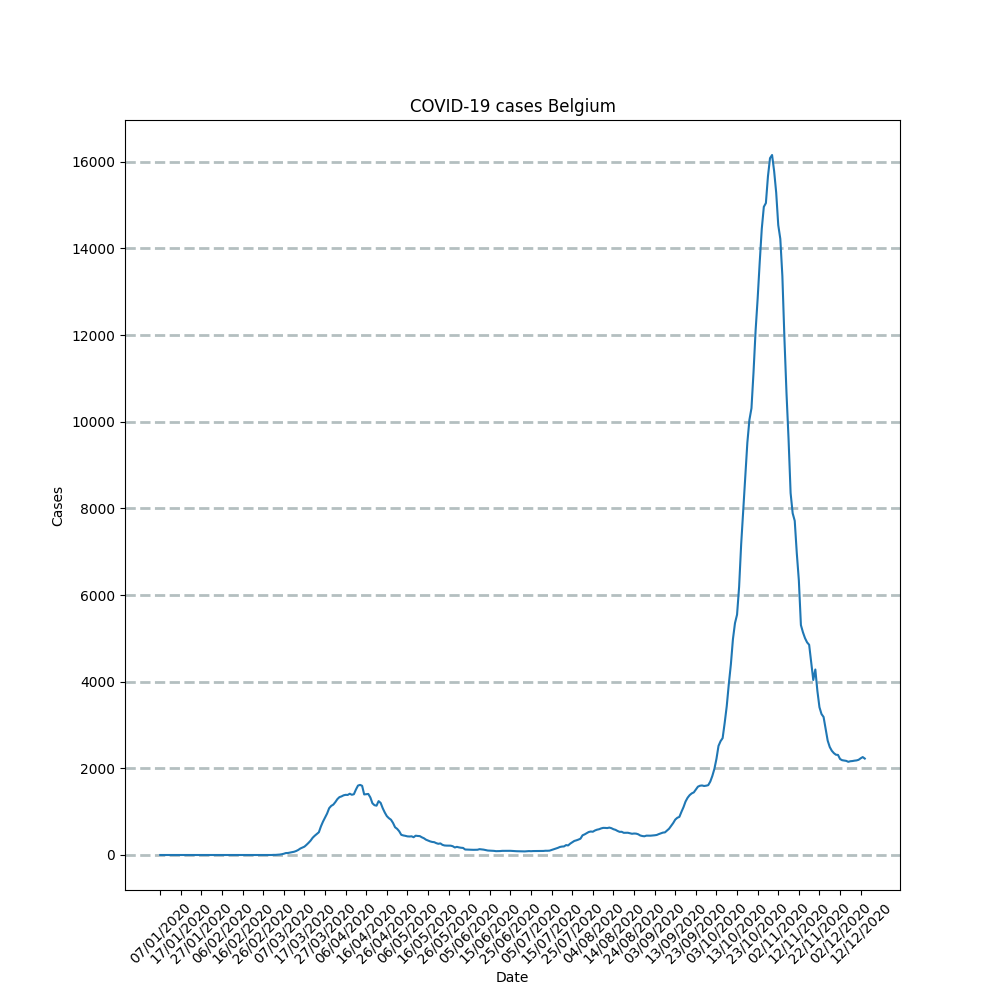

In [14]:
# Create a Figure with specified figure size.
fig = plt.figure(figsize=(10,10))

# Create a plot of date vs COVID-19 cases
plt.plot(weekly_avg_bel_dates, weekly_avg_bel_cases)

x = np.arange(weekly_avg_bel_dates.shape[0])
every = 10

# Customize the chart
plt.title('COVID-19 cases Belgium')
plt.xlabel('Date')
plt.xticks(np.arange(min(x), max(x)+1, every))
plt.ylabel('Cases')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Display the plot
%matplot plt

We can apply the same procedure to the neighboring countries "Netherlands" and "France".

In [15]:
# Repeat for Netherlands
spark.sql("CREATE VIEW IF NOT EXISTS covid_neth_view AS SELECT dateRep, cases, deaths FROM covid_table WHERE countriesAndTerritories == 'Netherlands' ")
covid_neth_pandasdf = spark.sql("SELECT * FROM covid_neth_table").toPandas()
weekly_avg_neth_dates = covid_neth_pandasdf.dateRep.loc[::-1]
weekly_avg_neth_cases = covid_neth_pandasdf.cases.loc[::-1]
weekly_avg_neth_dates, weekly_avg_neth_cases = calc_weekly_averages(weekly_avg_neth_dates, weekly_avg_neth_cases)

# Repeat for France
spark.sql("CREATE VIEW IF NOT EXISTS covid_fra_view AS SELECT dateRep, cases, deaths FROM covid_table WHERE countriesAndTerritories == 'France' ")
covid_fra_pandasdf = spark.sql("SELECT * FROM covid_fra_table").toPandas()
weekly_avg_fra_dates = covid_fra_pandasdf.dateRep.loc[::-1]
weekly_avg_fra_cases = covid_fra_pandasdf.cases.loc[::-1]
weekly_avg_fra_dates, weekly_avg_fra_cases = calc_weekly_averages(weekly_avg_fra_dates, weekly_avg_fra_cases)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let us plot these three countries together. This can be easily achieved by recycling the previous code cells.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

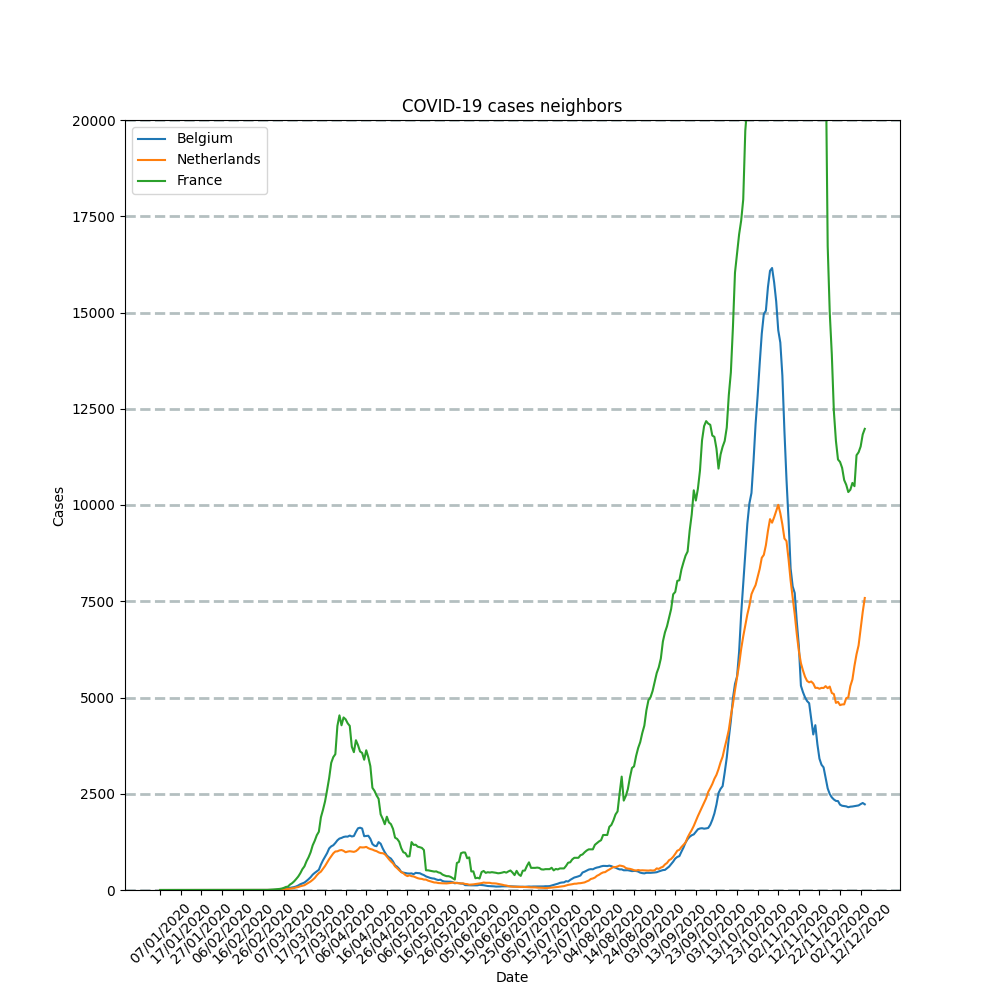

In [16]:
# Create a Figure with specified figure size.
fig = plt.figure(figsize=(10,10))

# Create a plot of date vs COVID-19 cases
plt.plot(weekly_avg_bel_dates, weekly_avg_bel_cases, label="Belgium")
plt.plot(weekly_avg_neth_dates, weekly_avg_neth_cases, label="Netherlands") # Add the Netherlands cases
plt.plot(weekly_avg_fra_dates, weekly_avg_fra_cases, label="France") # Add the France cases

x = np.arange(weekly_avg_bel_dates.shape[0])
every = 10

# Customize the chart
plt.title('COVID-19 cases neighbors')
plt.xlabel('Date')
plt.xticks(np.arange(min(x), max(x)+1, every))
plt.ylabel('Cases')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Display the plot
plt.ylim(0, 20000)
plt.legend(loc="upper left")
%matplot plt

## Descriptive analysis

Let us explore the methods that manipulate the Hive Tables.

In Belgium, the first COVID-19 wave started approx. at 1 March 2020 and terminated approx. on 25 May 2020. Let us select the data during the first COVID-19 wave. This can be achieved by:
- Using the **WHERE** query to filter the covid cases from the first wave by giving a boolean condition.
- Using the **RLIKE** query to construct the boolean condition where the column *covid_bel_table.dateRep* contains '/03/2020', '/04/2020' or '/05/2020' (i.e. whether the dates are in March, April or May).
- Saving this in a new temporary view **covid_bel_fw_table**.

In [17]:
spark.sql("CREATE VIEW IF NOT EXISTS covid_bel_fw_view AS SELECT * FROM covid_bel_view WHERE dateRep RLIKE '/03/2020|/04/2020|/05/2020' ")
spark.sql("SELECT * FROM covid_bel_fw_view").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+------+
|   dateRep|cases|deaths|
+----------+-----+------+
|31/05/2020|   61|    23|
|30/05/2020|  165|    16|
|29/05/2020|  171|    26|
|28/05/2020|  182|    24|
|27/05/2020|  202|    24|
|26/05/2020|  314|    26|
|25/05/2020|   75|    33|
|24/05/2020|  123|    25|
|23/05/2020|  248|    41|
|22/05/2020|   70|    34|
|21/05/2020|  385|    30|
|20/05/2020|  292|    33|
|19/05/2020|  317|    37|
|18/05/2020|   81|    31|
|17/05/2020|  147|    30|
|16/05/2020|  347|    45|
|15/05/2020|  305|    43|
|14/05/2020|  321|    56|
|13/05/2020|  395|    45|
|12/05/2020|  476|    65|
+----------+-----+------+
only showing top 20 rows

Imagine that the National Health Organisation of Belgium will declare the days where the COVID-19 cases are above 800 as "critical". We can add a new column in the Spark DataFrame to indicate the critical days. This can be done using again the **SELECT** query. Afterwards, we create a new view from this expanded table.

In [18]:
spark.sql("CREATE VIEW IF NOT EXISTS covid_bel_fw_view2 AS SELECT *, cases >= 800 AS is_critical FROM covid_bel_fw_view")
spark.sql("SELECT * FROM covid_bel_fw_view2").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+------+-----------+
|   dateRep|cases|deaths|is_critical|
+----------+-----+------+-----------+
|31/05/2020|   61|    23|      false|
|30/05/2020|  165|    16|      false|
|29/05/2020|  171|    26|      false|
|28/05/2020|  182|    24|      false|
|27/05/2020|  202|    24|      false|
|26/05/2020|  314|    26|      false|
|25/05/2020|   75|    33|      false|
|24/05/2020|  123|    25|      false|
|23/05/2020|  248|    41|      false|
|22/05/2020|   70|    34|      false|
|21/05/2020|  385|    30|      false|
|20/05/2020|  292|    33|      false|
|19/05/2020|  317|    37|      false|
|18/05/2020|   81|    31|      false|
|17/05/2020|  147|    30|      false|
|16/05/2020|  347|    45|      false|
|15/05/2020|  305|    43|      false|
|14/05/2020|  321|    56|      false|
|13/05/2020|  395|    45|      false|
|12/05/2020|  476|    65|      false|
+----------+-----+------+-----------+
only showing top 20 rows

Hive Tables are designed for tabular data, and you can use them to perform many kinds of data analytics operation you can do in a relational database; such as grouping and aggregating tables of data.

For example, using the **GROUP BY** query, we can
- Count the number of days that are "critical" using the **COUNT** query.
- Find the average of the covid cases during the critical and non-critical days using the **MEAN** method.

> More information can be found [here](https://www.tutorialspoint.com/hive/hiveql_group_by.htm).

This can be done like this:

In [19]:
spark.sql("SELECT is_critical, COUNT(*) FROM covid_bel_fw_view2 GROUP BY is_critical").show()

spark.sql("SELECT is_critical, MEAN(cases) FROM covid_bel_fw_view2 GROUP BY is_critical").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------+
|is_critical|count(1)|
+-----------+--------+
|       true|      26|
|      false|      66|
+-----------+--------+

+-----------+------------------+
|is_critical|        avg(cases)|
+-----------+------------------+
|       true|1451.6538461538462|
|      false|321.27272727272725|
+-----------+------------------+

From these numbers of the data, we can make some statements:
- "During the first COVID-19 wave of Belgium, 26 days were 'critical' while the remaining 66 days were 'not-critical'."
- "During the first COVID-19 wave of Belgium, the average number of confirmed COVID-19 cases was 1451 during the 'critical' days and 321 during the 'non-critical' days."

Based on the methods used, HiveQL infers a column name. We could improve the last table by renaming the column names to our liking and rounding the average cases. This can be done using the **ROUND** query and the **AS** query for renaming every column name.

> More information and other built in functions in Hive can be found [here](https://www.tutorialspoint.com/hive/hive_built_in_functions.htm).

In [20]:
from pyspark.sql import functions as func

spark.sql("SELECT is_critical AS CriticalDay, ROUND(MEAN(cases), 0) AS AverageCases FROM covid_bel_fw_view2 GROUP BY is_critical").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------+
|CriticalDay|AverageCases|
+-----------+------------+
|       true|      1452.0|
|      false|       321.0|
+-----------+------------+

Finally, let us plot the COVID-19 cases of Belgium during the first wave, highlighting the days that were "critical" and count the "critical" days in a piechart. We shall do this using the subplot method of **matplotlib**.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

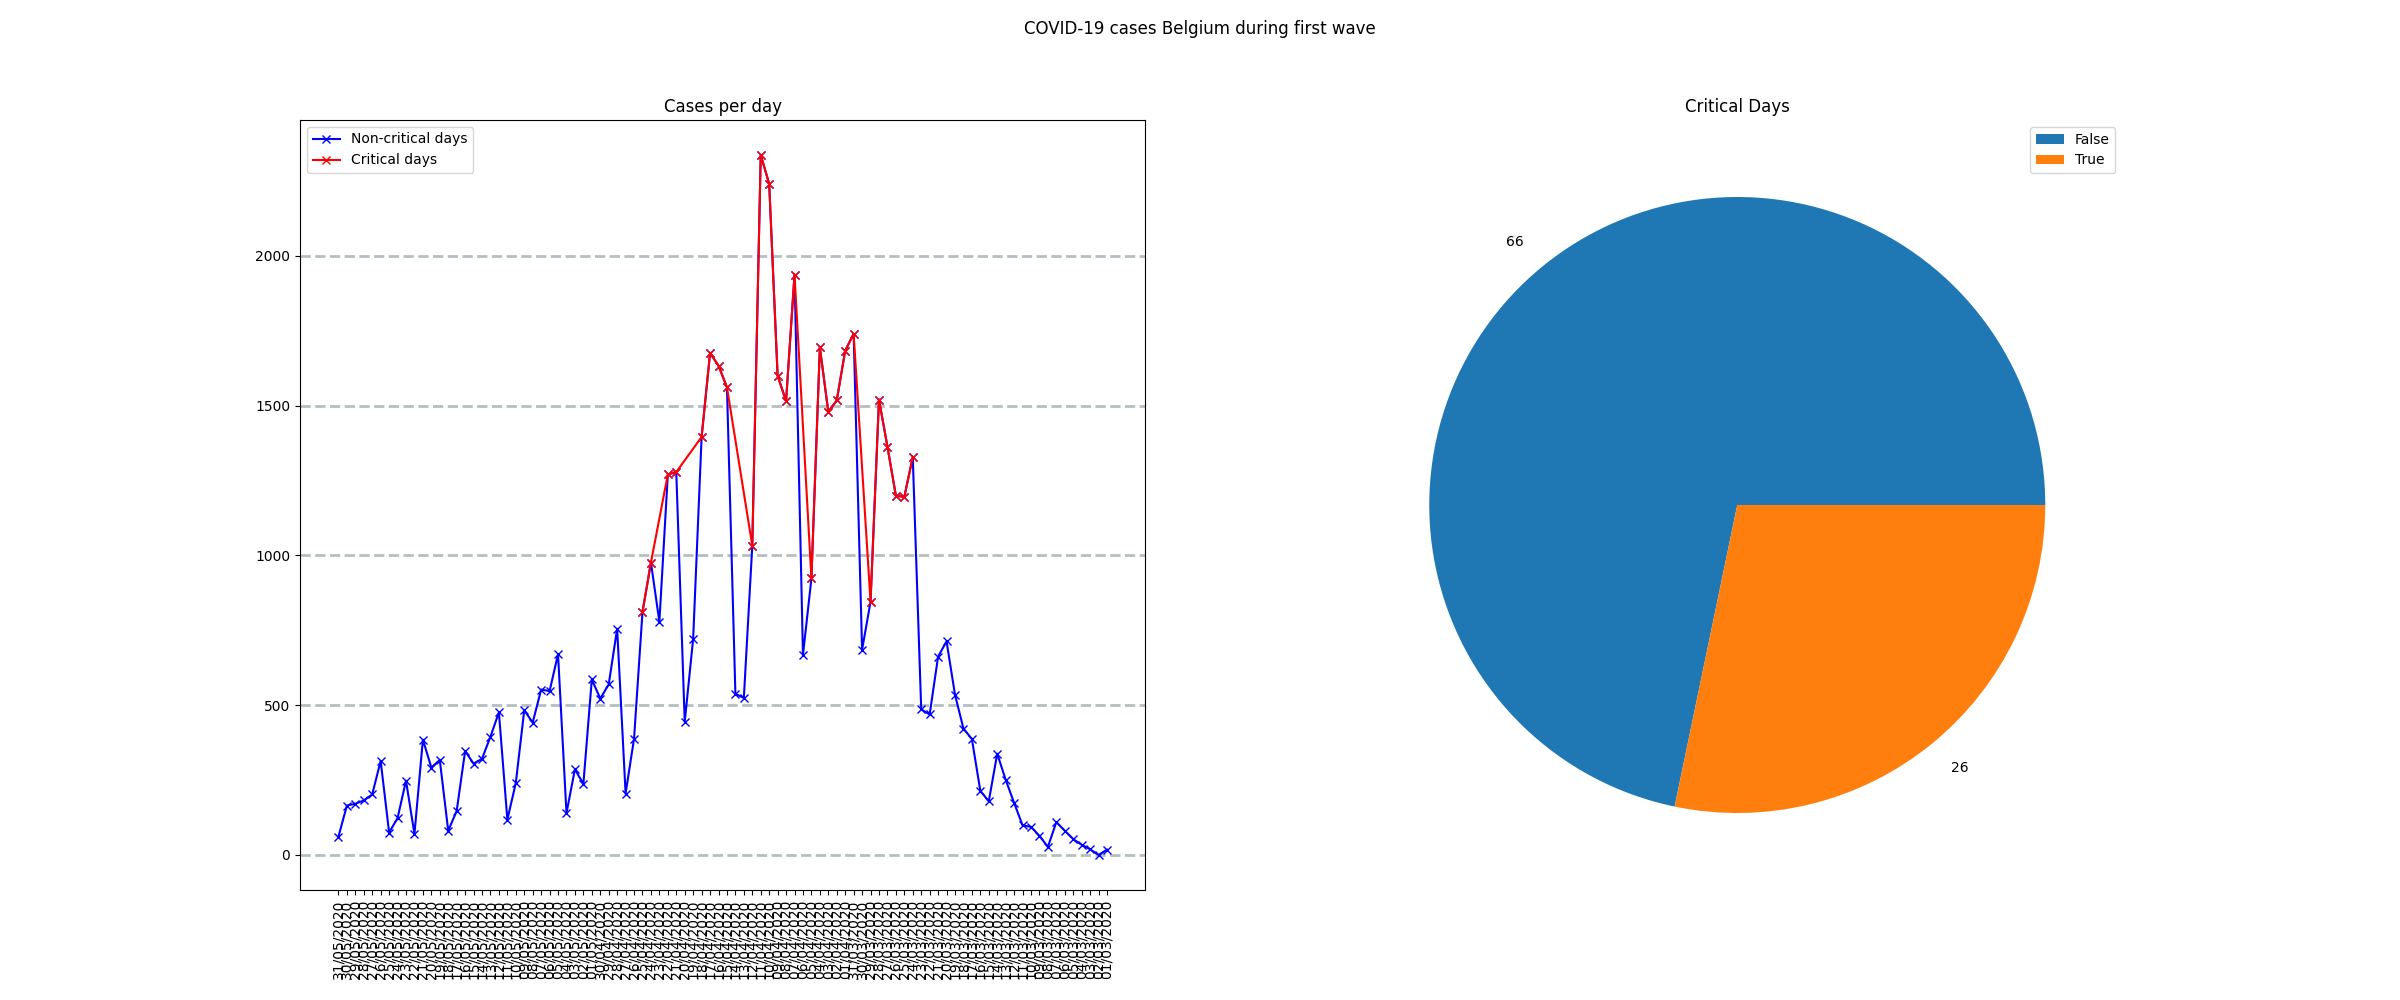

In [21]:
import matplotlib.ticker as tk

# Translating to Pandas DataFrame
covid_bel_fw_pandasdf = spark.sql("SELECT * FROM covid_bel_fw_view2").toPandas()

# Create a Figure with specified figure size.
fig, ax = plt.subplots(1, 2, figsize=(24,10))

# Create first plot of date vs COVID-19 cases (indicating the critical days)
ax[0].plot(covid_bel_fw_pandasdf.dateRep, covid_bel_fw_pandasdf.cases, 
            label = "Non-critical days", color = "blue", marker="x")
ax[0].plot(covid_bel_fw_pandasdf.dateRep[covid_bel_fw_pandasdf.is_critical], covid_bel_fw_pandasdf.cases[covid_bel_fw_pandasdf.is_critical], 
            label = "Critical days", color = "red", marker="x")

# Customize the chart
ax[0].grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax[0].set_xticklabels(covid_bel_fw_pandasdf.dateRep, rotation=90)
ax[0].legend(loc="upper left")
ax[0].set_title('Cases per day')

# Create a second plot with pie chart of is_critical counts
is_critical_counts = covid_bel_fw_pandasdf['is_critical'].value_counts()
ax[1].pie(is_critical_counts, labels=is_critical_counts)
ax[1].set_title('Critical Days')
ax[1].legend(is_critical_counts.keys().tolist())

# Display the plot
fig.suptitle('COVID-19 cases Belgium during first wave')
%matplot plt

## Statistical analysis

Now you have some idea of using PySpark to manipulate and visualize data. Let us start analyzing it.
A lot of data science is rooted in statistics, so we'll explore some basic statistical concepts.

### Descriptive statistics and data distribution
When examining a variable (for example the COVID-19 cases in Belgium), data scientists are particularly interested in its distribution (in other words, how are all the different grade values spread across the sample).

#### Measures of central tendency
To understand the distribution better, we can examine so-called measures of central tendency; which is a fancy way of describing statistics that represent the "middle" of the data. The goal of this is to try to find a "typical" value. Common ways to define the middle of the data include:

- The mean: A simple average based on adding together all of the values in the sample set, and then dividing the total by the number of samples.
- The median: The value in the middle of the range of all of the sample values.

Let's calculate these values using Hive queries for the "critical" and "non-critical" days.

In [22]:
# Define new views for future use, one indicating the critical days and one for the non-critical days
spark.sql("CREATE VIEW IF NOT EXISTS covid_bel_fw_crit_view AS SELECT dateRep, cases, deaths FROM covid_bel_fw_view2 WHERE is_critical")
spark.sql("CREATE VIEW IF NOT EXISTS covid_bel_fw_noncrit_view AS SELECT dateRep, cases, deaths FROM covid_bel_fw_view2 WHERE NOT is_critical")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[]

In [23]:
# Get statistics
min_val = spark.sql("SELECT MAX(cases) FROM covid_bel_fw_view2").head()[0]
max_val = spark.sql("SELECT MIN(cases) FROM covid_bel_fw_view2").head()[0]

# Get the mean and median of "critical" days
mean_crit = spark.sql("SELECT MEAN(cases) FROM covid_bel_fw_crit_view").head()[0]
med_crit = spark.sql("SELECT PERCENTILE(cases, 0.5) FROM covid_bel_fw_crit_view").head()[0]

# Get the mean and median of "non-critial" days
mean_noncrit = spark.sql("SELECT MEAN(cases) FROM covid_bel_fw_noncrit_view").head()[0]
med_noncrit = spark.sql("SELECT PERCENTILE(cases, 0.5) FROM covid_bel_fw_noncrit_view").head()[0]

# Print the results
print('Minimum:{:.2f}\nMaximum:{:.2f}\n \n'.format(min_val, max_val))
print('Critial days:\nMean:{:.2f}\nMedian:{:.2f}\n \n'.format(mean_crit, med_crit))
print('Non-critical days\nMean:{:.2f}\nMedian:{:.2f}\n'.format(mean_noncrit, med_noncrit))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Minimum:2336.00
Maximum:0.00
 

Critial days:
Mean:1451.65
Median:1497.00
 

Non-critical days
Mean:321.27
Median:298.50

The median was calculated using the **PERCENTILE** query given the argument 0.5, which returns the value such that 50% of the data is below this value, which is the definition of the median. 

For more information on Hive operators, please go to the [LanguageManual UDF](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF). 

The *.head()[0]* method was needed to extract the single value of the Spark DataFrame to store in a variable.

### Measures of variance
There's another aspect of distributions we can examine: how much variability is there in the data?

Typical statistics that measure variability in the data include:
- Range: The difference between the maximum and minimum. There's no built-in function for this, but it's easy to calculate using the min and max functions.
- Variance: The average of the squared difference from the mean. You can use the built-in **var** method to find this.
- Standard Deviation: The square root of the variance. You can use the built-in **std** method to find this.

In [24]:
rng = spark.sql("SELECT MAX(cases)-MIN(cases) FROM covid_bel_fw_crit_view").head()[0]
var = spark.sql("SELECT VARIANCE(cases) FROM covid_bel_fw_crit_view").head()[0]
std = spark.sql("SELECT STDDEV(cases) FROM covid_bel_fw_crit_view").head()[0]
print('\n Critical days:\n - Range: {:.2f}\n - Variance: {:.2f}\n - Std.Dev: {:.2f}'.format(rng, var, std))

rng = spark.sql("SELECT MAX(cases)-MIN(cases) FROM covid_bel_fw_noncrit_view").head()[0]
var = spark.sql("SELECT VARIANCE(cases) FROM covid_bel_fw_noncrit_view").head()[0]
std = spark.sql("SELECT STDDEV(cases) FROM covid_bel_fw_noncrit_view").head()[0]
print('\n Non-critical days:\n - Range: {:.2f}\n - Variance: {:.2f}\n - Std.Dev: {:.2f}'.format(rng, var, std))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


 Critical days:
 - Range: 1525.00
 - Variance: 145743.76
 - Std.Dev: 381.76

 Non-critical days:
 - Range: 778.00
 - Variance: 48191.28
 - Std.Dev: 219.53

Of these statistics, the standard deviation is generally the most useful. It provides a measure of variance in the data on the same scale as the data itself. The higher the standard deviation, the more variance there is when comparing values in the distribution to the distribution mean - in other words, the data is more spread out.

## Appendix 1: The normal distribution

When working with a normal distribution (also called Gaussian distribution), the standard deviation works with the particular characteristics of a normal distribution to provide even greater insight. Run the cell below to see the relationship between standard deviations and an variable assumed to have a normal distribution.

In [25]:
sc = spark.sparkContext
sc.install_pypi_package("scipy") #Install scipy

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/b6/3a/9e0649ab2d5ade703baa70ef980aa08739226e5d6a642f084bb201a92fc2/scipy-1.6.1-cp37-cp37m-manylinux1_x86_64.whl

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

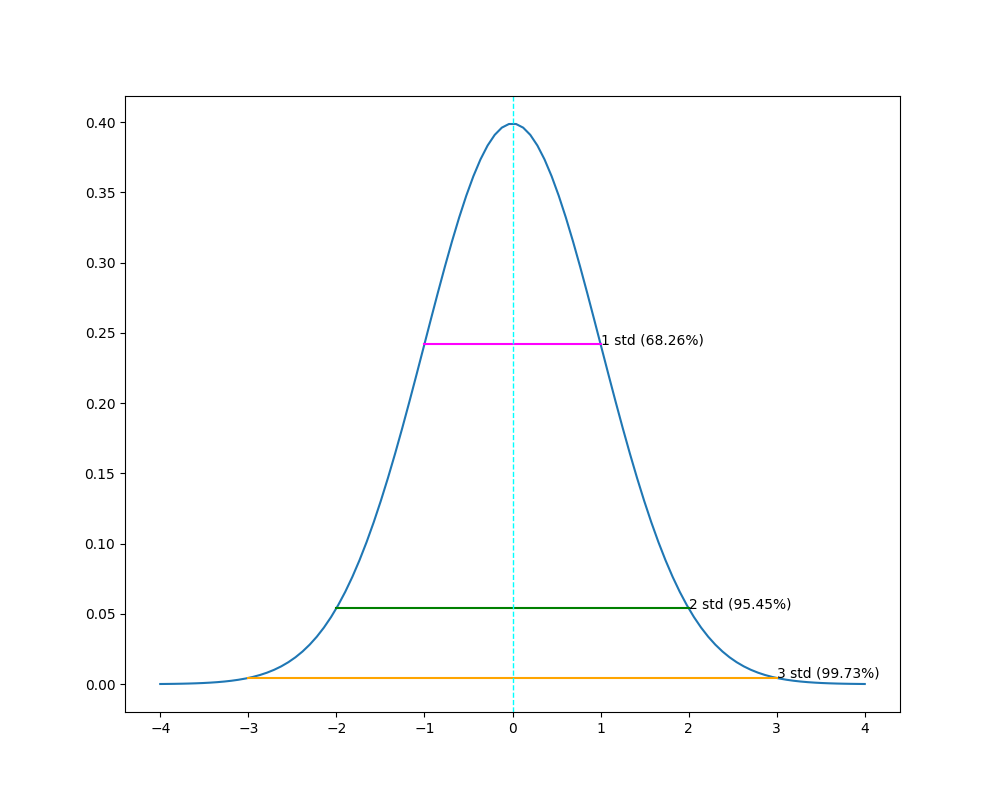

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

# Create a Figure
fig = plt.figure(figsize=(10,8))

# Plot the density
mu = 0
variance = 1
s = math.sqrt(variance)
x = np.linspace(mu - 4*s, mu + 4*s, 100)
plt.plot(x, stats.norm.pdf(x, mu, s))

# Annotate 1 stdev
x1 = [mu-s, mu+s]
y1 = stats.norm.pdf(x1, mu, s)
plt.plot(x1,y1, color='magenta')
plt.annotate('1 std (68.26%)', (x1[1],y1[1]))

# Annotate 2 stdevs
x2 = [mu-(s*2), mu+(s*2)]
y2 = stats.norm.pdf(x2, mu, s)
plt.plot(x2,y2, color='green')
plt.annotate('2 std (95.45%)', (x2[1],y2[1]))

# Annotate 3 stdevs
x3 = [mu-(s*3), mu+(s*3)]
y3 = stats.norm.pdf(x3, mu, s)
plt.plot(x3,y3, color='orange')
plt.annotate('3 std (99.73%)', (x3[1],y3[1]))

# Show the location of the mean
plt.axvline(mu, color='cyan', linestyle='dashed', linewidth=1)

# plt.axis('off')
%matplot plt

The horizontal lines show the percentage of data within 1, 2, and 3 standard deviations of the mean (plus or minus).

In any normal distribution:
- Approximately 68.26% of values fall within one standard deviation from the mean.
- Approximately 95.45% of values fall within two standard deviations from the mean.
- Approximately 99.73% of values fall within three standard deviations from the mean.

## Cleaning up

If you are finished with the SPARK session, you could remove all the created views and tables in this tutorials. This can be done using the **DROP** query of Hive.

In [27]:
spark.sql("DROP VIEW IF EXISTS covid_bel_fw_crit_view")
spark.sql("DROP VIEW IF EXISTS covid_bel_fw_noncrit_view")
spark.sql("DROP VIEW IF EXISTS covid_bel_fw_view2")
spark.sql("DROP VIEW IF EXISTS covid_bel_fw_view")
spark.sql("DROP VIEW IF EXISTS covid_fra_view")
spark.sql("DROP VIEW IF EXISTS covid_neth_view")
spark.sql("DROP VIEW IF EXISTS covid_bel_view")
spark.sql("DROP TABLE IF EXISTS covid_table")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[]

Finally, it is recommended to stop the Spark session. To do this, you can use the **stop** method of the SPARK session,

In [28]:
spark.stop()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…